<a href="https://colab.research.google.com/github/SciEcon/merge-private-public-mempool/blob/main/Validator_Rewards_After_the_Merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
from random import randrange, random, sample
from datetime import datetime, timedelta
from time import time
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

In [3]:
class Ecdf(pd.Series):
    def __init__(self, data):
        s = pd.Series(data)
        super().__init__(s.value_counts().sort_index().cumsum()*1./len(s))
        
    def get_quantile(self, q):
        #self[self.ge(random())].index[0]
        return self.index[np.argmax(self.array >= q)] # faster
        
    def get_scaled_ecdf(self, scaling_factor):
        index = [v * scaling_factor for v in self.index.values]
        scaled_ecdf = self.set_axis(index)
        scaled_ecdf.__class__ = Ecdf
        return scaled_ecdf

In [ ]:
df = pd.DataFrame(np.random.exponential(scale=2/3, size=10000), columns = ['miner_extracted'])

In [14]:
# simulate a year's worth of block proposals
SECONDS_PER_SLOT = 12.0
mev_ecdf = Ecdf(df['miner_extracted'])
# calculate average block interval
mean_interval = 12.58
scaling_factor = SECONDS_PER_SLOT / mean_interval
scaled_mev_ecdf = mev_ecdf.get_scaled_ecdf(scaling_factor)

num_validators = 420000
validators = [0] * num_validators
validators_h1 = [0] * num_validators
validators_h2 = [0] * num_validators
seconds_per_year = 31556952
slots_per_year = int(seconds_per_year // SECONDS_PER_SLOT)

start_time = time()
last_update = 0

for slot in range(slots_per_year):
    # random selection of validator as proposer
    ind = randrange(num_validators)
    rn = random()
    # random sampling of MEV level for the block
    validators[ind] += scaled_mev_ecdf.get_quantile(rn)
    
    t = time()
    if t - last_update > 0.1:
        percentage = 100 * (slot+1) / slots_per_year
        elapsed = timedelta(seconds=int(t - start_time))
        print(f"{percentage:.2f}% / {elapsed} elapsed", end='\r')
        last_update = t

rtn = pd.Series([100 * v / 32 for v in validators])
annual_mev_ecdf = Ecdf(rtn)

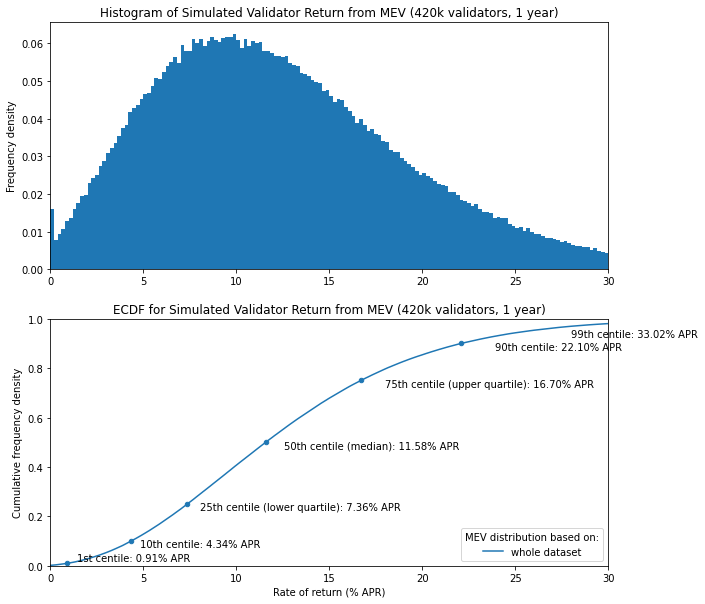

In [17]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

bins = [e/5 for e in range(151)]
rtn.hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title(
    'Histogram of Simulated Validator Return from MEV (420k validators, 1 year)'
)
ax1.set_xlim(0, 30)
ax1.set_ylabel('Frequency density')

annual_mev_ecdf.plot(ax=ax2, label="whole dataset")
quantiles = [.01, .1, .25, .5, .75, .9, .99, .999]

table = pd.DataFrame({
    'quantile': quantiles,
    'centile': [100 * q for q in quantiles],
    'all': [annual_mev_ecdf.get_quantile(q) for q in quantiles],
})
table.set_index('quantile', inplace=True, drop=False)
table.plot('all', 'quantile', kind='scatter', ax=ax2)

c1 = table['all'].loc[0.01]
ax2.annotate(f'1st centile: {c1:.2f}% APR', (c1 + 0.5, 0.02))
d1 = table['all'].loc[0.1]
ax2.annotate(f'10th centile: {d1:.2f}% APR', (d1 + 0.5, 0.075))
lq = table['all'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {lq:.2f}% APR', (lq + 0.7, 0.225))
med = table['all'].loc[0.5]
ax2.annotate(f'50th centile (median): {med:.2f}% APR', (med + 1, 0.475))
uq = table['all'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {uq:.2f}% APR', (uq + 1.3, 0.725))
d9 = table['all'].loc[0.9]
ax2.annotate(f'90th centile: {d9:.2f}% APR', (d9 + 1.8, 0.875))
c99 = table['all'].loc[0.99]
ax2.annotate(f'99th centile: {c99:.2f}% APR', (c99 - 5, 0.925))

ax2.set_title(
    'ECDF for Simulated Validator Return from MEV (420k validators, 1 year)'
)
ax2.set_xlabel('Rate of return (% APR)')
ax2.set_xlim(0, 30)
ax2.set_ylabel('Cumulative frequency density')
ax2.set_ylim(0, 1)
ax2.legend(title='MEV distribution based on:', loc='lower right')

plt.show()

table.drop('quantile', axis=1, inplace=True)
cols = [
    ('','Centile<br>(%)'),
    ('Rate of return (% APR)<br>based on data from:','Sep 2021<br>to Aug 2022'),
]

fmts = ['{:.1f}'] + ['{:.2f}'] * 3
col_formats = {c: f for c, f in zip(cols, fmts)}
table.columns = pd.MultiIndex.from_tuples(cols)

In [ ]:
num_validators = 420000

HEAD_WT = 14
SOURCE_WT = 14
TARGET_WT = 26
SYNC_WT = 2
PROPOSER_WT = 8
BASE_REWARD_FACTOR = 64
WEIGHT_DENOM = 64
EPOCHS_PER_COMMITTEE = 256
COMMITTEE_SIZE = 512
SLOTS_PER_EPOCH = 32
GWEI_PER_ETH = int(1e9)
gwei_per_validator = int(32e9)
staked_gwei = gwei_per_validator * num_validators
epochs_per_year = slots_per_year // SLOTS_PER_EPOCH

base_reward = gwei_per_validator * BASE_REWARD_FACTOR // math.isqrt(staked_gwei)
total_reward = base_reward * num_validators

att_reward = base_reward * (HEAD_WT + SOURCE_WT + TARGET_WT) // WEIGHT_DENOM
annual_attestation_reward_eth = att_reward * epochs_per_year / GWEI_PER_ETH

# perfect performance so all validators get full attestation reward for the year
validators = [annual_attestation_reward_eth] * num_validators

prop_reward = total_reward * PROPOSER_WT // WEIGHT_DENOM // SLOTS_PER_EPOCH
prop_reward_eth = prop_reward / GWEI_PER_ETH
sync_reward = total_reward * SYNC_WT // WEIGHT_DENOM // SLOTS_PER_EPOCH \
              // COMMITTEE_SIZE
sync_reward_eth = sync_reward / GWEI_PER_ETH

start_time = time()
last_update = 0

for slot in range(slots_per_year):
    # process sync committee:
    if slot % (32 * EPOCHS_PER_COMMITTEE) == 0:
        # select sync committee
        committee = sample(range(num_validators), COMMITTEE_SIZE)
    for ind in committee:
        validators[ind] += sync_reward_eth
        validators_h1[ind] += sync_reward_eth
        validators_h2[ind] += sync_reward_eth
            
    # random selection of validator as proposer
    ind = randrange(num_validators)
    r = random()
    validators[ind] += scaled_mev_ecdf.get_quantile(r) + prop_reward_eth

    t = time()
    if t - last_update > 0.1:
        percentage = 100 * (slot+1) / slots_per_year
        elapsed = timedelta(seconds=int(t - start_time))
        print(f"{percentage:.2f}% / {elapsed} elapsed", end='\r')
        last_update = t

annual_full_rtn = pd.Series([100 * v / 32 for v in validators])
annual_full_ecdf = Ecdf(annual_full_rtn)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

bins = [e/5 for e in range(176)]
annual_full_rtn.hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title(
    'Histogram of Simulated Validator Rate of Return (420k validators, 1 year)'
)
ax1.set_xlim(0, 35)
ax1.set_ylabel('Frequency density')

quantiles = [0, .01, .1, .25, .5, .75, .9, .99, .999, 1]

table = pd.DataFrame({
    'quantile': quantiles,
    'centile': [100 * q for q in quantiles],
    'all': [annual_full_ecdf.get_quantile(q) for q in quantiles],
})
table.set_index('quantile', inplace=True, drop=False)
table.plot('all', 'quantile', kind='scatter', ax=ax2)

annual_full_ecdf.plot(ax=ax2, label="whole dataset")

                  
c1 = table['all'].loc[0.01]
ax2.annotate(f'1st centile: {c1:.2f}% APR', (c1 + 0.7, 0.02))
d1 = table['all'].loc[0.1]
ax2.annotate(f'10th centile: {d1:.2f}% APR', (d1 + 0.7, 0.075))
lq = table['all'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {lq:.2f}% APR', (lq + 1, 0.225))
med = table['all'].loc[0.5]
ax2.annotate(f'50th centile (median): {med:.2f}% APR', (med + 1, 0.475))
uq = table['all'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {uq:.2f}% APR', (uq + 1.3, 0.725))
d9 = table['all'].loc[0.9]
ax2.annotate(f'90th centile: {d9:.2f}% APR', (d9 + 1.8, 0.875))
c99 = table['all'].loc[0.99]
ax2.annotate(f'99th centile: {c99:.2f}% APR', (c99 - 6, 0.925))

ax2.set_title('Simulated Validator Rate of Return (420k validators, 1 year)')
ax2.set_xlabel('Rate of return (% APR)')
ax2.set_xlim(0, 35)
ax2.set_ylabel('Cumulative frequency density')
ax2.set_ylim(0, 1)
ax2.legend(title='MEV distribution based on:', loc='lower right')

plt.show()

table.drop('quantile', axis=1, inplace=True)
cols = [
    ('','Centile<br>(%)'),
    ('Rate of return (% APR)<br>based on data from:','Sep 2021<br>to Aug 2022'),
]

fmts = ['{:.1f}'] + ['{:.2f}'] * 3
col_formats = {c: f for c, f in zip(cols, fmts)}
table.columns = pd.MultiIndex.from_tuples(cols)